In [2]:
# packages
import pandas as pd
import numpy as np
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import pickle
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Load the Drive helper and mount
# from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
# pandas, read csv as a dataframe
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/training.csv')

df = pd.read_csv('./training.csv')

In [4]:
#fill nulls (only DISTANCE contains null)
nulls = df.isnull().sum().to_dict() # build a dictionary for null values
nan_columns = [col for col,null in nulls.items() if null>0] # find nulls
print(nan_columns)
df = df.fillna(df[nan_columns].mean()) # fill nulls with mean

['DISTANCE']


In [5]:
#desired dataframe
x = df[['DAY_OF_MONTH','CRS_ARR_H','CRS_DEP_H','DEP_DELAY','DISTANCE','DAYS_TO_HOLIDAY']].copy()
y = df['ARR_DELAY'].copy()
# print x

# split and shuffle
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0, shuffle=False)

In [12]:
df.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_H,ARR_HOUR,CRS_DEP_H,DEP_HOUR,ARR_DELAY,DEP_DELAY,DISTANCE,DAYS_TO_HOLIDAY
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,6.680767,15.763844,4.017933,1366.876556,13.172744,1283.252389,12.625756,-2.258000,29.867222,1855.542278,7.269689
std,3.336083,8.812137,2.006454,623.110033,6.317495,631.856303,6.408447,45.579419,33.875677,1830.702401,6.428238
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-217.000000,-50.000000,136.000000,0.000000
25%,4.000000,8.000000,2.000000,910.000000,8.000000,815.000000,8.000000,-20.000000,17.000000,714.000000,2.000000
50%,7.000000,16.000000,4.000000,1410.000000,14.000000,1325.000000,13.000000,-10.000000,24.000000,1422.000000,5.000000
75%,9.000000,23.000000,6.000000,1905.000000,18.000000,1830.000000,18.000000,5.000000,33.000000,2196.000000,11.000000
max,12.000000,31.000000,7.000000,2355.000000,23.000000,2355.000000,23.000000,2784.000000,2799.000000,11034.000000,28.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1F3FF770>,
      dtype=object)

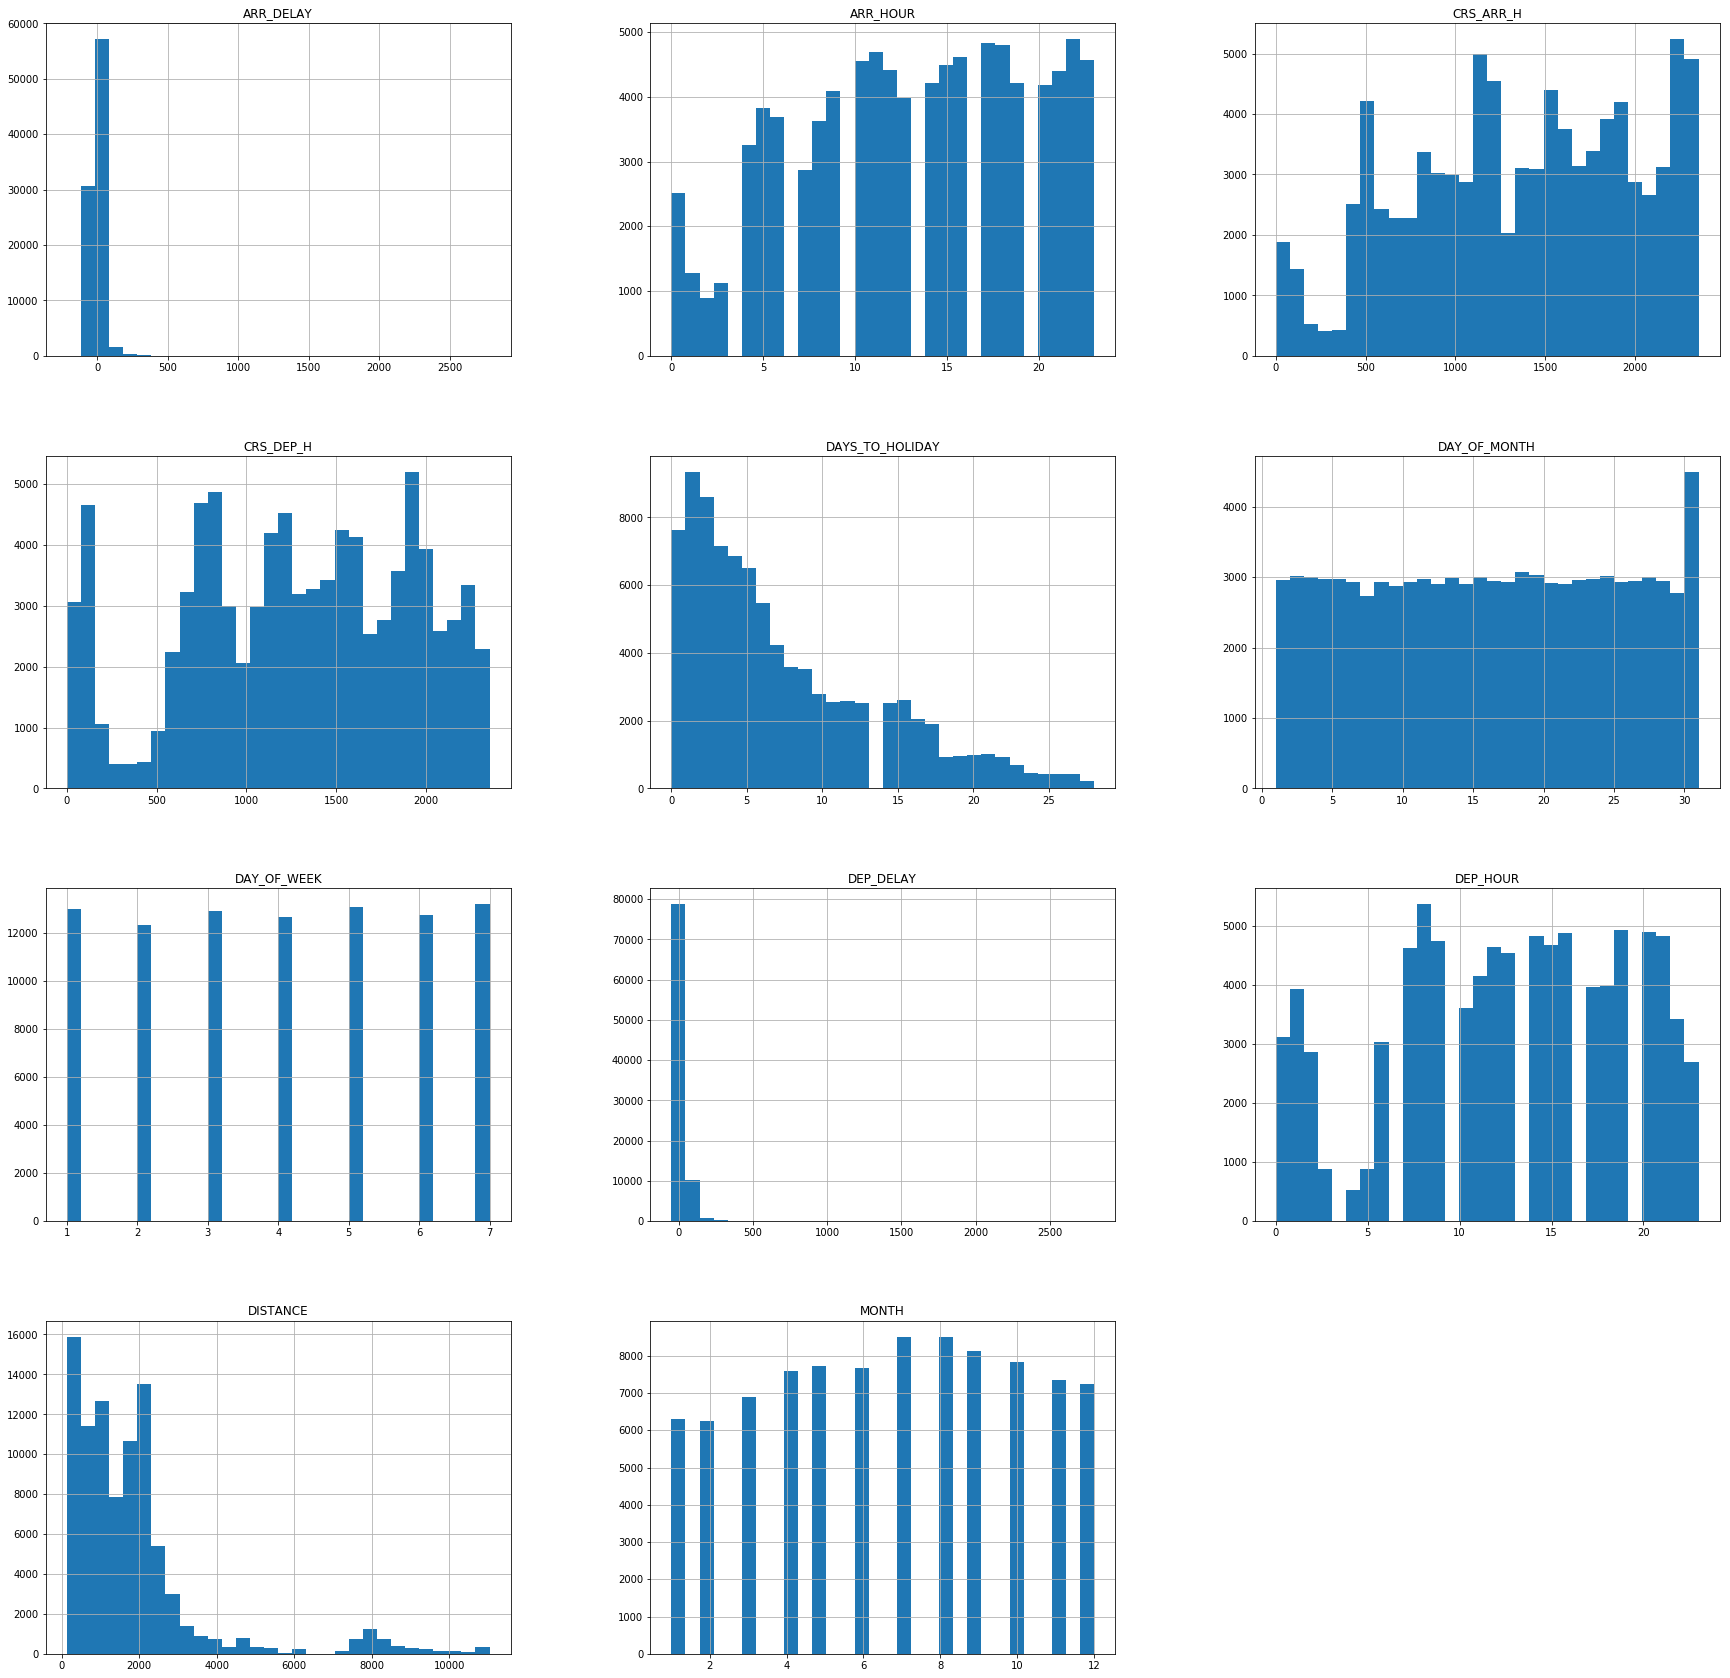

In [7]:
df.hist(bins=30, figsize=(30,30))

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x20F4A7D0>,
      dtype=object)

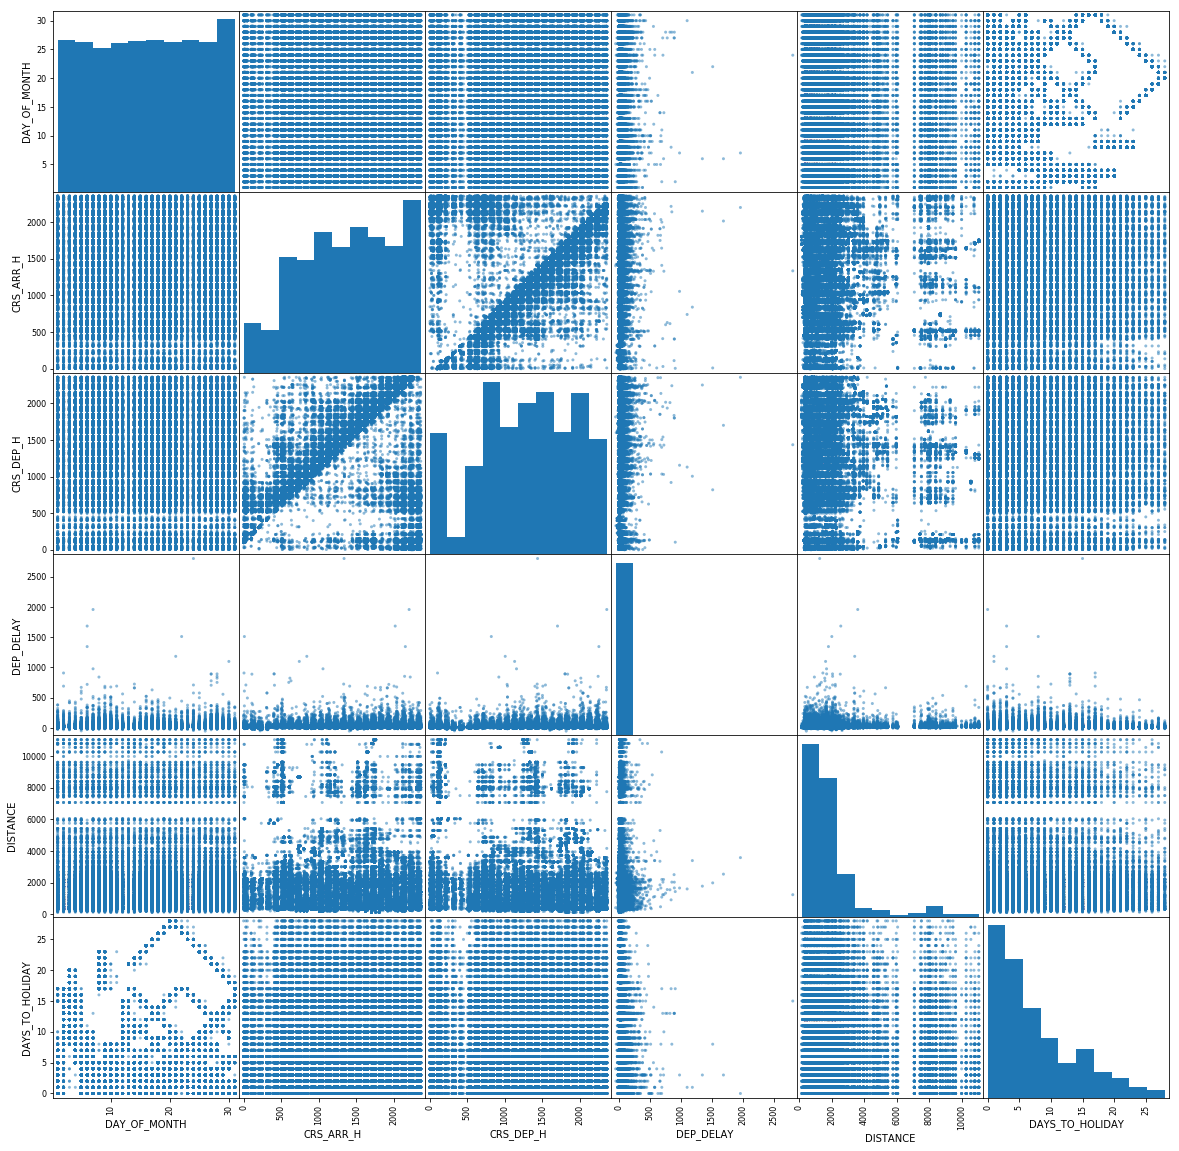

In [9]:
from pandas.tools.plotting import scatter_matrix

attributes = ["DAY_OF_MONTH","CRS_ARR_H","CRS_DEP_H","DEP_DELAY","DISTANCE","DAYS_TO_HOLIDAY"]
scatter_matrix(x[attributes], figsize=(20, 20))

# FINAL MODEL - AdaBoostRegressor

In [9]:
# 78 estimators
adaboost_model = AdaBoostRegressor(
    DecisionTreeRegressor(random_state=0,max_depth=90,max_features=3,min_samples_leaf=5,min_samples_split=5),
    random_state=0, n_estimators = 78
)
adaboost_model.fit(x_train,y_train)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=90, max_features=3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=78, random_state=0)

In [10]:
single_pred = adaboost_model.predict(x_test)
r2 = r2_score(y_test,single_pred)
rmse_ = np.sqrt(mean_squared_error(y_test,single_pred))
abs_er = mean_absolute_error(y_test,single_pred)
print(r2," ",rmse_," ",abs_er)

0.39160514560473014   36.793626797316435   16.401091459099394


In [11]:
# save model in pickle file
# pickle.dump(adaboost_model, open("./adaboost_model.pickle","wb"))
# adaboost_model_loaded = pickle.load(open("./adaboost_model.pickle","rb"))

# Random Forest with best parameters

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

params = {'n_estimators': [1000],
            'max_features': ['sqrt'],
            'max_depth': [50,70,90],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [2,4,6],
            'bootstrap': [True]}

#tree_model = tree.DecisionTreeRegressor()
#params = [{'n_estimators':[1000,5000,500,10000], 
 #          'max_features':[1,2,3,4,5,6]}]
#model_tuning = GridSearchCV(tree_model, params, cv=5)

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rndf_model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_model = GridSearchCV(rndf_model, params, cv=3)

In [0]:
# Fit the random search model
rf_random.fit(x_train, y_train)

In [0]:
predictions = rf.predict(x_test)


In [0]:
print(r2_score(y_test,predictions))
print(np.sqrt(mean_squared_error(y_test,predictions)))

# Random Forest randomly paramaters

In [0]:
# rf2 = RandomForestRegressor(n_estimators=1000, random_state=0)
# rnd_clf = RandomForestRegressor(random_state=0, 
#                                 n_estimators=1000,
#                                 max_features='sqrt',
#                                 max_depth=50,
#                                 min_samples_split=2,
#                                 min_samples_leaf=1,
#                                 bootstrap=True)
# rnd_clf.fit(x_train,y_train)

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [74]:
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 70.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 165.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 293.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 384.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [0]:
# save model in pickle file
# pickle.dump(grid_search, open("./grid_search_rndf.pickle","wb"))
grid_search_rndf = pickle.load(open("./grid_search_rndf.pickle","rb"))

In [104]:
print(grid_search_rndf)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)


In [76]:
# pred_tree = rnd_clf.predict(x_test)
# print(r2_score(y_test,pred_tree))
# print(np.sqrt(mean_squared_error(y_test,pred_tree)))



pred_tree = grid_search.predict(x_test)
print(r2_score(y_test,pred_tree))
print(np.sqrt(mean_squared_error(y_test,pred_tree)))

0.28080435324581765
40.00399439753423


In [80]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

# AdaBoost regressor

In [0]:
adaboost_model = AdaBoostRegressor(
#     DecisionTreeRegressor(random_state=0,max_depth=90,max_features=3,min_samples_leaf=5,min_samples_split=5),
    DecisionTreeRegressor(random_state=0),
    random_state=0
)

# 1# 2# 3# 4# 5# 6# 7# 8# 9# 10# 11# 12# 13# 14# 15# 16# 17# 18# 19# 20# 21# 22# 23# 24# 25# 26# 27# 28# 29# 30# 31# 32# 33# 34# 35# 36# 37# 38# 39# 40# 41# 42# 43# 44# 45# 46# 47# 48# 49# 50# 51# 52# 53# 54# 55# 56# 57# 58# 59# 60# 61# 62# 63# 64# 65# 66# 67# 68# 69# 70# 71# 72# 73# 74# 75# 76# 77# 78# 79# 80# 81# 82# 83# 84# 85# 86# 87# 88# 89# 90# 91# 92# 93# 94# 95# 96# 97# 98# 99

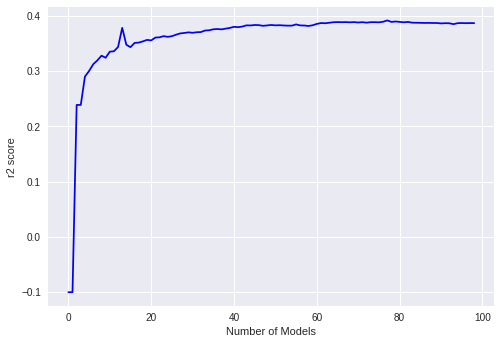

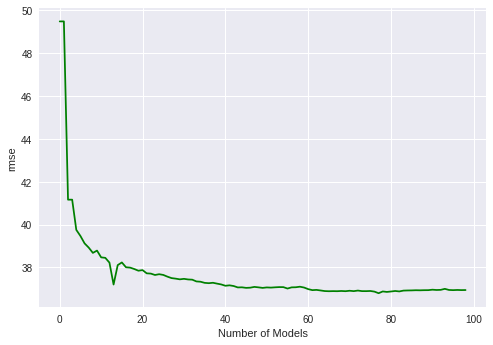

In [98]:
# PLOT
rmse = []
r2_scr = []
for i in range(1,100):
    adaboost_model.n_estimators = i
    adaboost_model.fit(x_train,y_train)
    
    test_pred = adaboost_model.predict(x_test)
    r2 = r2_score(y_test,test_pred)
    rmse_ = np.sqrt(mean_squared_error(y_test,test_pred))
    
    rmse.append(rmse_)
    r2_scr.append(r2)
    print("#", i, sep=' ', end='', flush=True) # progress bar
    
# plt.plot(train_accuracy, "r-+", label="train accuracy")
plt.plot(r2_scr, "b-+", label="r2 score")
plt.xlabel("Number of Models")
plt.ylabel("r2 score")
plt.show()
plt.plot(rmse, "g-+", label="RMSE")
plt.xlabel("Number of Models")
plt.ylabel("rmse")
plt.show()

In [0]:
plt.show()

In [102]:
print(np.max(r2_scr))
print(np.min(rmse))

print(r2_scr)
print(rmse)

0.39160514560473014
36.793626797316435
[-0.10032348285159376, -0.10032348285159376, 0.23863550298793534, 0.23863550298793534, 0.2899202673864608, 0.30008991234733584, 0.31226466177553724, 0.3192045467722978, 0.32775141745848846, 0.32402789223910433, 0.3350008917752756, 0.33577014287257356, 0.34343894469455394, 0.37813163767955005, 0.34747305692336417, 0.3431791641710171, 0.35089138208202686, 0.3514767657897231, 0.35369196843378037, 0.3563679546791886, 0.35539935090737784, 0.360522630670272, 0.3609683142330222, 0.36314109133634287, 0.36190933503772094, 0.36304482851301767, 0.36575945522318, 0.3680613389243702, 0.3689102121493206, 0.3699995605036277, 0.36921990832926743, 0.37017733055400026, 0.37052713285951944, 0.3732762769037633, 0.37374679949006395, 0.37552210862984625, 0.3760280972847764, 0.3753786943624361, 0.3767245243525543, 0.3780001198264099, 0.3800522649066407, 0.37937317886607536, 0.38045172072413436, 0.3826424116801175, 0.38247400762518813, 0.38331909765354166, 0.383037840048

# Grid seach tree

In [0]:
# Grid search
tree_model = tree.DecisionTreeRegressor()
params = [{'max_depth':[50,70,90,110], 
           'max_features':[3,4,5,6],
        'min_samples_split':[2,5,6],
         'min_samples_leaf':[1,2,3,4,5],
          }]
model_tuning = GridSearchCV(tree_model, params, cv=5)

In [0]:
model_tuning.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [50, 70, 90, 110], 'max_features': [3, 4, 5, 6], 'min_samples_split': [2, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
y_pred = model_tuning.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,y_pred)))
print(r2_score(y_test,y_pred))

44.81922473926761
0.09724684580019338


In [0]:
model_tuning.best_params_

{'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

# Greadient boosting

In [0]:
from sklearn.ensemble import GradientBoostingRegressor


In [0]:
gbrt = GradientBoostingRegressor(random_state=0,
                                max_features='sqrt',
                                max_depth=50,
                                min_samples_split=2,
                                min_samples_leaf=1)
gbrt.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=50,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=0,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
gbrt_pred = gbrt.predict(x_test)
print(r2_score(y_test,gbrt_pred))

0.29407887560533663


# Gradient Boosting n_estimator

############################################################

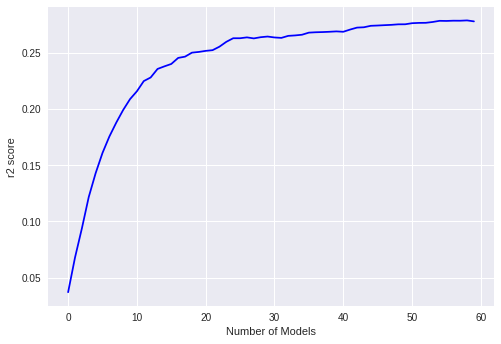

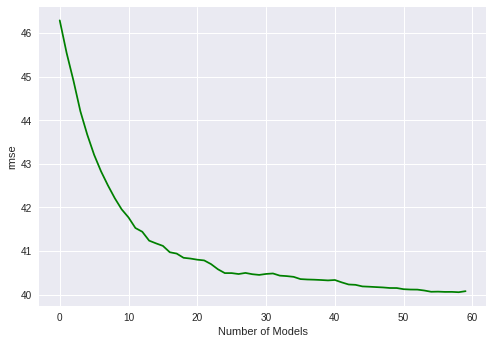

In [0]:
# PLOT
grd_tree = DecisionTreeRegressor(random_state=0,max_depth=90,max_features=3,min_samples_leaf=5,min_samples_split=5)
gbrt_model = GradientBoostingRegressor(random_state=0)
gbrt_rmse = []
gbrt_r2_scr = []
for i in range(1,61):
    gbrt_model.n_estimators = i
    gbrt_model.fit(x_train,y_train)
    
    gbrt_pred = gbrt_model.predict(x_test)
    gbrt_r2 = r2_score(y_test,gbrt_pred)
    gbrt_rmse_ = np.sqrt(mean_squared_error(y_test,gbrt_pred))
    
    gbrt_rmse.append(gbrt_rmse_)
    gbrt_r2_scr.append(gbrt_r2)
    print("#", sep=' ', end='', flush=True) # progress bar
    
# plt.plot(train_accuracy, "r-+", label="train accuracy")
plt.plot(gbrt_r2_scr, "b-+", label="r2 score")
plt.xlabel("Number of Models")
plt.ylabel("r2 score")
plt.show()
plt.plot(gbrt_rmse, "g-+", label="RMSE")
plt.xlabel("Number of Models")
plt.ylabel("rmse")
plt.show()

In [101]:


print(min(gbrt_rmse))
print(max(gbrt_r2_scr))
print(gbrt_rmse)
print(gbrt_r2_scr)

40.05541120146768
0.2789544126910346
[46.29055069823545, 45.544358527053845, 44.905303074030684, 44.20639366022893, 43.67024260259737, 43.20747072598136, 42.829229313869305, 42.50743716800203, 42.21265326511366, 41.95704078730104, 41.770661726653074, 41.52830334216523, 41.44245911058489, 41.23815965157487, 41.17574294120858, 41.118061670994415, 40.97222559813397, 40.94154765174862, 40.844963996593, 40.827456591269616, 40.801588967949726, 40.78461651378073, 40.699896546536216, 40.581365150372434, 40.493850612785536, 40.49368557382438, 40.47261717247604, 40.49784228203451, 40.46832990547147, 40.45227489322996, 40.47459297783645, 40.48536179082411, 40.43567690526987, 40.42482622073812, 40.40809399580684, 40.35641257354971, 40.34730648609555, 40.34256014240767, 40.33531114866612, 40.326027915791286, 40.335437293932024, 40.28097618957485, 40.23282948816136, 40.224736298025846, 40.188652040989716, 40.18149207725469, 40.172958715609894, 40.16488520398565, 40.152103442605465, 40.15103475260965